In [1]:
# synth_images = [os.path.join(synth_path, i) for i in os.listdir(synth_path) if i.endswith(".png")]
# benchmark_images = [os.path.join(benchmark_path, i) for i in os.listdir(benchmark_path) if i.endswith(".png")]
# shuffle(benchmark_images)
# benchmark_images = benchmark_images[:len(synth_images)]
# fatura_images = [os.path.join(fatura_path, i) for i in os.listdir(fatura_path) if i.endswith(".png")]
# inference = Inference(model_path="weights/doc_deduplication_final.pth")

# synth_embeddings = inference.get_all_embeddings(synth_images)
# np.save("embeddings/synth_embeddings.npy", synth_embeddings)
# benchmark_embeddings = inference.get_all_embeddings(benchmark_images)
# np.save("embeddings/benchmark_embeddings.npy", benchmark_embeddings)
# fatura_embeddings = inference.get_all_embeddings(fatura_images)
# np.save("embeddings/fatura_embeddings.npy", fatura_embeddings)

In [1]:
from src.measure_dataset import *
import os
import warnings
import numpy as np

warnings.filterwarnings("ignore")

synth_path = "data/synth_dataset/images"
benchmark_path = "data/funsd_benchmark/images"
fatura_path = "data/fatura/images"

# Load fixed benchmark labels
with open("data/benchmark_labels.txt", "r") as f:
    benchmark_labels = f.read().split("\n")[:-1]
benchmark_labels_path = "data/funsd_benchmark/layoutlm_labels"

# Load fixed synthetic labels
with open("data/synth_labels.txt", "r") as f:
    synth_labels = f.read().split("\n")[:-1]
synth_labels_path = "data/synth_dataset/layoutlm_labels"

# Load fatura labels
fatura_labels_path = "data/fatura/layoutlm_labels"
fatura_labels = [i for i in os.listdir(fatura_labels_path) if i.endswith(".json")]

synth_bboxes, synth_pii_bboxes, synth_pii_bboxes_dict, synth_doc_bboxes, synth_doc_pii_bboxes = get_bboxes(
    synth_labels, synth_labels_path, synth_path
)
benchmark_bboxes, benchmark_pii_bboxes, benchmark_pii_bboxes_dict, benchmark_doc_bboxes, benchmark_doc_pii_bboxes = get_bboxes(
    benchmark_labels, benchmark_labels_path, benchmark_path
)
fatura_bboxes, fatura_pii_bboxes, fatura_pii_bboxes_dict, fatura_doc_bboxes, fatura_doc_pii_bboxes = get_bboxes(
    fatura_labels, fatura_labels_path, fatura_path
)

synth_embeddings = np.load("data/synth_embeddings.npy")
benchmark_embeddings = np.load("data/benchmark_embeddings.npy")
fatura_embeddings = np.load("data/invoices_embeddings.npy")

## Visualization of bboxes

### PII entities distribution

#### Benchmark pii entities

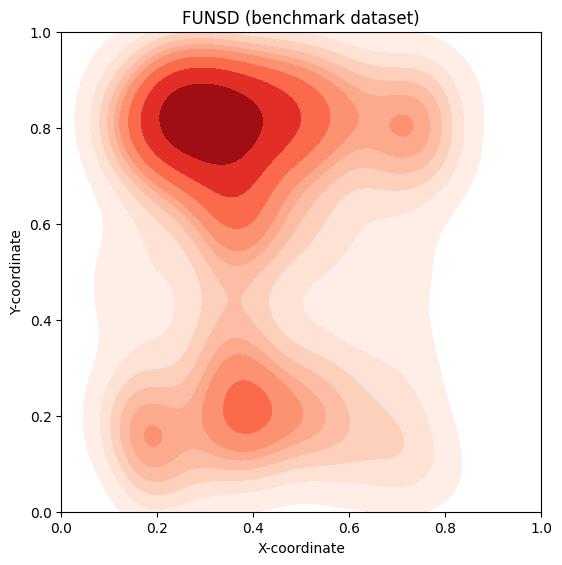

In [2]:
plot_heatmap_all(benchmark_pii_bboxes, "FUNSD (benchmark dataset)")

#### Synthetic pii entities

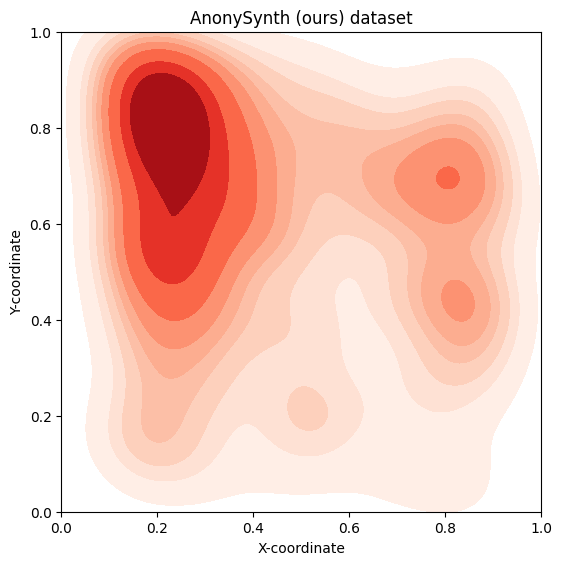

In [3]:
plot_heatmap_all(synth_pii_bboxes, "AnonySynth (ours) dataset")

#### fatura pii entities

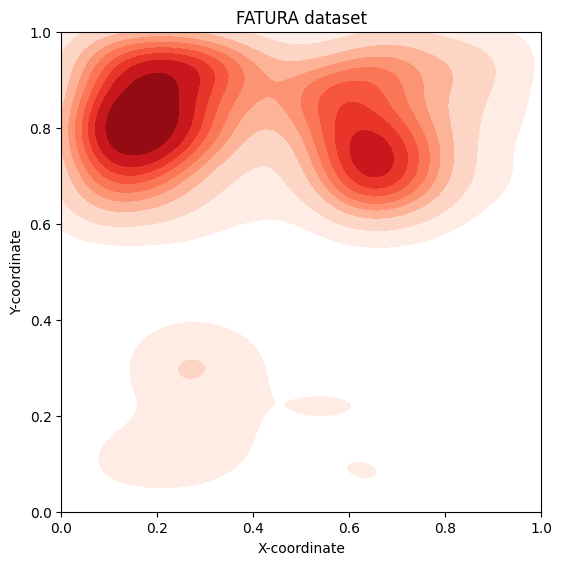

In [4]:
plot_heatmap_all(fatura_pii_bboxes, "FATURA dataset")

### Coverage Ratio
This metric will show what percentage (%) of the total page area is occupied by bounding boxes (i.e., text areas).

- A high coverage percentage indicates that the document is densely filled with text.

- A low percentage indicates that there is a lot of free space.

📌 How to calculate Coverage Ratio (%)

To calculate:

- Sum the areas of all bounding boxes on the page.

- Divide the sum of the areas of the bounding boxes by the total area of the page.

- Multiply by 100%.



In [5]:
print("Benchmark:", calculate_dataset_coverage(benchmark_doc_pii_bboxes))
print("Synthetic dataset:", calculate_dataset_coverage(synth_doc_pii_bboxes))
print("FATURA:", calculate_dataset_coverage(fatura_doc_pii_bboxes))

Benchmark: 2.500577893121919
Synthetic dataset: 4.832446465747993
FATURA: 2.382422409572799


### Percentage of diversity of PII bbox locations (Diversity Score)
This metric will reflect not the density, but how evenly the bounding boxes are distributed across the page.

How to calculate it:

- Divide the page into a grid (for example, 5x5 = 25 cells).

- Check each cell:

    - if there is at least one bounding box (or the center of the bounding box) in the cell, then it is "filled".
    
    - if not, it is "empty".
- Calculate the percentage of filled cells from the total number of cells.

Thus, the metric becomes independent of density, but reflects the diversity and uniformity of the location of bounding boxes on the page:

- High percentage: bounding boxes are evenly and diversely distributed across the entire page.

- Low percentage: bounding boxes are concentrated only in some areas.

In [6]:
print("Benchmark:", dataset_diversity_score(benchmark_doc_pii_bboxes))
print("Synthetic dataset:", dataset_diversity_score(synth_doc_pii_bboxes))
print("FATURA:", dataset_diversity_score(fatura_doc_pii_bboxes))

Benchmark: 31.25
Synthetic dataset: 54.25
FATURA: 31.443298969072163


### Percentage of unique bbox locations (Layout Uniqueness)

This metric shows what percentage of the bbox locations (at the grid level) in the document is unique relative to the entire dataset.

Steps to calculate:
1. The page is divided into a fixed grid (for example, 5×5).

2. For each document, a binary grid mask is created:

    - 1 if there is at least one bbox in the cell
    
    - 0 if the cell is empty
    
3. It is counted how often each grid mask occurs in the dataset.

4. Unique are the documents whose grid occurs only once.

5. Metric: percentage of unique documents in the dataset.

Thus, even if the bbox-ies are "scattered" throughout the document, but the same in different documents (for example, the same cells are filled), the metric will show a low percentage of uniqueness.

In [7]:
print("Benchmark:", calculate_layout_uniqueness(benchmark_doc_pii_bboxes))
print("Synthetic dataset:", calculate_layout_uniqueness(synth_doc_pii_bboxes))
print("FATURA:", calculate_layout_uniqueness(fatura_doc_pii_bboxes))

Benchmark: 77.22772277227723
Synthetic dataset: 96.0
FATURA: 29.896907216494846


### Images copmarison: Intradiversity

In [8]:
print("Бенчмарк:", compute_intradiversity(benchmark_embeddings))
print("Синтетический датасет:", compute_intradiversity(synth_embeddings))
print("fatura:", compute_intradiversity(fatura_embeddings))

Бенчмарк: 10.308747
Синтетический датасет: 8.284759
fatura: 7.126327
